In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/social-media-engagement/social_media_engagement1.csv


In [2]:
df = pd.read_csv("/kaggle/input/social-media-engagement/social_media_engagement1.csv")
df.head()

,post_id,platform,post_type,post_time,likes,comments,shares,post_day,sentiment_score
0,1,Facebook,image,8/17/2023 14:45,2121,474,628,Thursday,positive
1,2,Facebook,carousel,5/14/2023 0:45,3660,432,694,Sunday,neutral
2,3,Instagram,poll,2/21/2023 16:15,4955,408,688,Tuesday,negative
3,4,Twitter,image,11/16/2023 0:45,1183,90,187,Thursday,negative
4,5,Twitter,video,5/23/2023 0:30,3499,247,286,Tuesday,positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   post_id          100 non-null    int64 
 1   platform         100 non-null    object
 2   post_type        100 non-null    object
 3   post_time        100 non-null    object
 4   likes            100 non-null    int64 
 5   comments         100 non-null    int64 
 6   shares           100 non-null    int64 
 7   post_day         100 non-null    object
 8   sentiment_score  100 non-null    object
dtypes: int64(4), object(5)
memory usage: 7.2+ KB


## 1. What Time of Day Generates the Most Engagement

In [4]:
df['total_engagement'] = df['likes'] + df['comments'] + df['shares']
df['hour'] = pd.to_datetime(df['post_time']).dt.hour

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 23:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)


engagement_by_time = df.groupby('time_of_day')['total_engagement'].mean().sort_values(ascending=False)
print(engagement_by_time)


time_of_day
Night        3472.666667
Afternoon    2934.840000
Evening      2779.571429
Morning      2759.555556
Name: total_engagement, dtype: float64


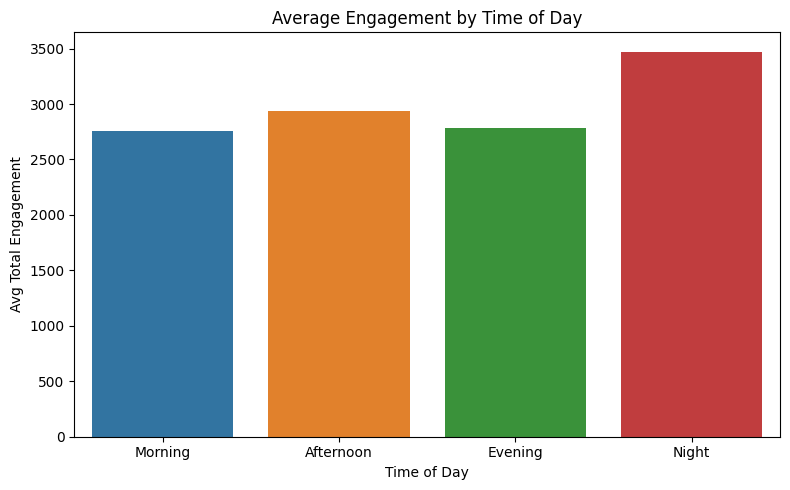

In [5]:
time_engagement = df.groupby('time_of_day')['total_engagement'].mean().reindex(['Morning', 'Afternoon', 'Evening', 'Night'])


plt.figure(figsize=(8,5))
sns.barplot(x=time_engagement.index, y=time_engagement.values)
plt.title("Average Engagement by Time of Day")
plt.ylabel("Avg Total Engagement")
plt.xlabel("Time of Day")
plt.tight_layout()
plt.show()


## 2. Which Platform Has the Most Consistent Engagement Across Times

In [6]:
platform_time_std = df.groupby(['platform', 'time_of_day'])['total_engagement'].std().unstack()

platform_consistency = platform_time_std.std(axis=1).sort_values()
print(platform_consistency)


platform
Facebook     322.883126
Twitter      327.070480
Instagram    433.555415
dtype: float64


<Figure size 1000x600 with 0 Axes>

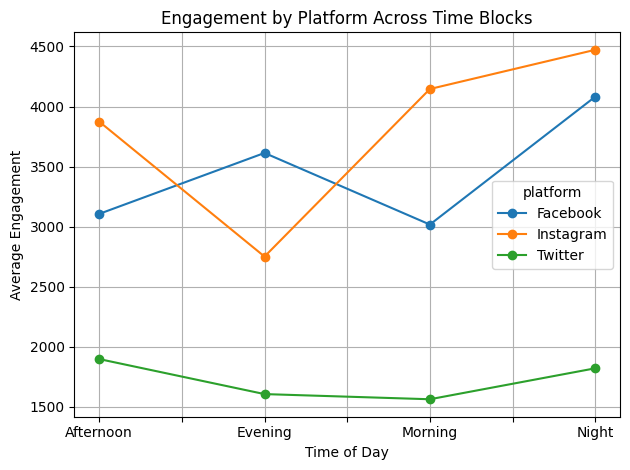

In [7]:
platform_time_std = df.groupby(['platform', 'time_of_day'])['total_engagement'].mean().unstack()

plt.figure(figsize=(10,6))
platform_time_std.T.plot(kind='line', marker='o')
plt.title("Engagement by Platform Across Time Blocks")
plt.ylabel("Average Engagement")
plt.xlabel("Time of Day")
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Can We Predict Engagement Score Using Regression

In [8]:
df['hour'] = pd.to_datetime(df['post_time']).dt.hour
features = df[['platform', 'post_type', 'post_day', 'sentiment_score', 'hour']]
target = df['total_engagement']


X = pd.get_dummies(features, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)



RMSE: 1463.2141669080754


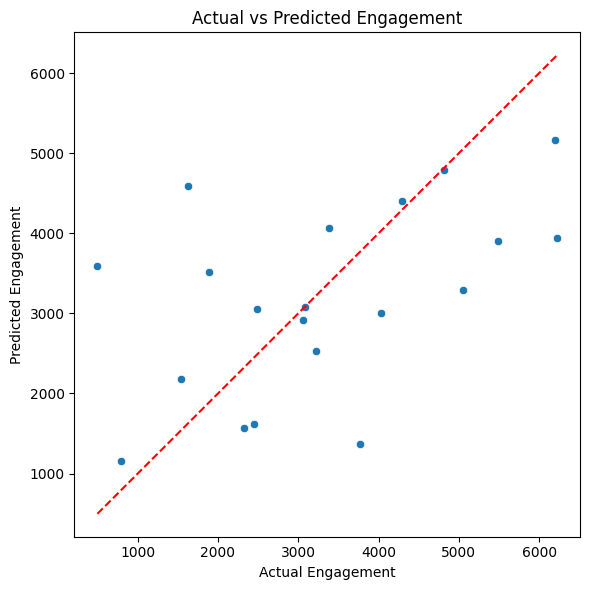

In [9]:
# Scatterplot of predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 1:1 line
plt.xlabel("Actual Engagement")

plt.ylabel("Predicted Engagement")
plt.title("Actual vs Predicted Engagement")
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Feature Importance (Linear Regression)'}>

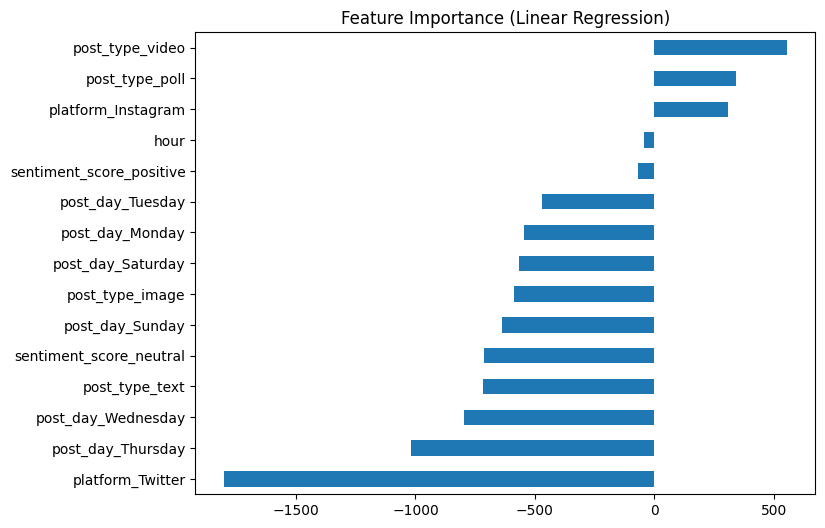

In [10]:
coefs = pd.Series(model.coef_, index=X.columns)
coefs.sort_values().plot(kind='barh', figsize=(8,6), title="Feature Importance (Linear Regression)")


In [11]:
df['hour'] = pd.to_datetime(df['post_time']).dt.hour
features = df[['platform', 'post_type', 'post_day', 'sentiment_score', 'hour']]
target = df['total_engagement']


X = pd.get_dummies(features, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)


Random Forest RMSE: 1614.7869772155707


In [12]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)


y_pred_gb = gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("Gradient Boosting RMSE:", rmse_gb)


Gradient Boosting RMSE: 1814.142121217403
